Test Simu de MC avec vol local. Comme mon mondèle de dupire ne marche pas je vais juste le faire avec la VI pour le moment

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from ModuleFinance import *

c:\Program64\Python\Python\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class MonteCarlo:
    def __init__(self, Udl: MarketData, T: float, NB_Pas: int, NB_Simu: int) -> None:
        """
        Classe pour effectuer des simulations de Monte Carlo sur un actif.
        Les Simulations sont multi-threadé afin d'aller le plus vite possible. 
        J'ai choisit d'utiliser une classe car c'est plus simple de manipuler
        le module njit avec une classe et ainsi de multi-threadé.

        Paramètres
        ----------
        Udl : MarketData
            Les données de marché nécessaires pour les simulations.
        T : float
            La maturité.
        NB_Pas : int
            Le nombre de pas pour la simulation.
        NB_Simu : int
            Le nombre de simulations.
        Seed : int
            Si spécifié alors la valeur est attribué comme seed du random generator

        Méthodes
        ----------
        Stantard(self) -> np.ndarray:
            Effectue une simulation Monte Carlo standard/

        RV_Correl(self) -> np.ndarray:
            Effectue une simulation Monte Carlo avec des variables aléatoires corrélées négativement.
        """
        self.S = float(Udl.Spot)
        self.r = float(Udl.get_rate(T))
        self.q = float(Udl.get_div(T))
        self.T = float(T)
        self.N = int(NB_Pas)
        self.M = int(NB_Simu)
        self.Vol = float(Udl.get_vol(self.T,self.S))
        self.Vol_Local = Udl.Vol_Local
           
    def vol_standard(self) -> np.ndarray:
        """
        Effectue une simulation Monte Carlo avec Vol B&S.

        Returns
        -------
        np.ndarray
            Array représentant les résultats de la simulation.
        """
        return _standard_vol(self.S, self.Vol, self.r, self.q, self.T, self.N, self.M)

    def RV_Correl(self) -> np.ndarray:
        """
        Effectue une simulation Monte Carlo avec des variables aléatoires corrélées négativement. 
        Le prix du produit doit être le même peut-importe mon mouvement brownien. 
        Ainsi si on génère une second spot qui a correl de mouvement brownien de -1,
        nous avons besoin de moins de simulation.  De plus cela permet de réduire la variance de mon modèle 
        et donc par la même occasion le Stantard Error de mon prix.

        Returns
        -------
        np.ndarray
            Array représentant les résultats de la simulation.
        """
        return _RV_Correl(self.S, self.Vol, self.r, self.q, self.T, self.N, self.M)

    def vol_local(self) -> np.ndarray:
        """
        Effectue une simulation Monte Carlo avec la Vol Local.

        Returns
        -------
        np.ndarray
            Array représentant les résultats de la simulation.

        Raises
        ------
        TypeError
            Si la vol local n'est pas disponible alors il retourne une erreur.
        """
        if isinstance(self.Vol_Local, VISurface):
            nb_jour = 365 * self.T
            mat_inf_T = [mat for mat in self.Vol_Local.index if mat < nb_jour]
            if nb_jour in self.Vol_Local.index:
                mat_inf_T.append(nb_jour)

            mat_inf_T = np.array(mat_inf_T)
            columns = np.array(self.Vol_Local.columns)
            mat_nb_pas_MC = np.sort(np.array([round(mat * self.N / 360, 2) if mat < 365 else round(mat * self.N / 365, 2) for mat in mat_inf_T]))

            spline_list = np.array([np.array(CubicSpline(pd.DataFrame(self.Vol_Local.loc[mat, :])).calculate_spline_coefficients()) for mat in mat_inf_T])
            return _local_vol(self.S, self.r, self.q, self.T, self.N, self.M, mat_nb_pas_MC, columns, spline_list)
        else:
            raise TypeError("Nous avons besoin d'une nap de VI afin de réaliser une simulation en Volatilité Local.")

    def vol_sto(self, Correl: float, Variance: float, Kappa:float, Theta:float, vol_vol:float) -> np.ndarray:
        """
        Effectue une simulation Monte Carlo avec la Vol Sto.

        Parameters
        ----------
        Correl : float
            Correlation entre les 2 mouvements brownien
        Variance : float
            La variance intial
        Kappa : float
            La vitesse de retour à la variance moyenne
        Theta : float
            La variance moyenne
        vol_vol : float
            La Vol de Vol

        Returns
        -------
        np.ndarray
            Array représentant les résultats de la simulation.
        """
        return _vol_sto(self.S, self.r, self.q, self.T, self.N, self.M, Correl, Variance, Kappa, Theta, vol_vol)

@njit(parallel=True, fastmath=True, nogil=True)
def _standard_vol(S: float, Vol: float, r: float, q: float, T: float, N: int, M: int) -> np.ndarray:
    drift = ((r - q) - (Vol**2) / 2) * (1 / N)
    diffusion = Vol * np.sqrt(1 / N)
    Longeur = int((N * T) + 1)
    array = np.zeros((M, Longeur), dtype=float)
    for i in prange(M):
        array[i, 0] = S
        for J in range(1, Longeur):
            array[i, J] = array[i, J - 1] * np.exp(drift + np.random.normal() * diffusion)
    return array

@njit(parallel=True, fastmath=True, nogil=True)
def _RV_Correl(S: float, Vol: float, r: float, q: float, T: float, N: int, M: int) -> np.ndarray:
    M = int(M/2)
    drift = ((r-q) - (Vol**2)/2)*(1/N)
    diffusion = Vol*np.sqrt(1/N)
    Longeur = int((N * T) + 1)
    array3D = np.zeros((M, Longeur, 2), dtype=float)
    for i in prange(M):
        array3D[i, 0, 0] = S
        array3D[i, 0, 1] = S
        for J in range(1,Longeur):
            mvt_brownien = np.random.normal()
            array3D[i, J, 0] = array3D[i, J - 1, 0] * np.exp(drift + mvt_brownien * diffusion)
            array3D[i, J, 1] = array3D[i, J - 1, 1] * np.exp(drift - mvt_brownien * diffusion)
    return array3D

@njit(parallel=True, fastmath=True, nogil=True)
def _local_vol(S: float, r: float, q: float, T: float, N: int, M: int, index:np.ndarray, columns:np.ndarray, equa_spline:np.ndarray) -> np.ndarray:
    Longueur = int((N * T) + 1)
    dt = 1 / N
    array = np.zeros((M, Longueur), dtype=float)
    for i in prange(M):
        array[i, 0] = S
        for J in range(1, Longueur):
        #je dois récupéré la vol pour le spot précédent et la vol précedent
            for iloc_mat, mat in enumerate(index):
                if J == mat:
                    spline = equa_spline[iloc_mat]
                    for iloc_k, k in enumerate(columns):
                        if array[i, J-1] <= k: break
                    if iloc_k == 0:
                        coef = spline[iloc_k]
                        Vol = coef[0] * k ** 3 + coef[1] * k ** 2 + coef[2] * k + coef[3]
                    else:
                        iloc_k -= 1
                        coef = spline[iloc_k]
                        if iloc_k == len(spline)-1:
                            Vol = coef[0] * k ** 3 + coef[1] * k ** 2 + coef[2] * k + coef[3]
                        else:
                            Vol = coef[0] * array[i, J-1] ** 3 + coef[1] * array[i, J-1] ** 2 + coef[2] * array[i, J-1] + coef[3]
                    # print(iloc_k, coef,k)
                    break
                elif J < mat:
                    # I need to calculate the spline above and below to interpolate linearly.
                    if iloc_mat != 0:
                        mat_basse = iloc_mat - 1
                        mat_hautte = iloc_mat
                        # Calculate the two smiles
                        spline_bas = equa_spline[mat_basse]
                        spline_haut = equa_spline[mat_hautte]
                        for iloc_k, k in enumerate(columns):
                            if array[i, J-1] == k or array[i, J-1] < k: break
                        if iloc_k == 0:
                            VI1 = spline_bas[iloc_k][0] * k ** 3 + spline_bas[iloc_k][1] * k ** 2 + spline_bas[iloc_k][2] * k + spline_bas[iloc_k][3]
                            VI2 = spline_haut[iloc_k][0] * k ** 3 + spline_haut[iloc_k][1] * k ** 2 + spline_haut[iloc_k][2] * k + spline_haut[iloc_k][3]
                        else:
                            iloc_k -= 1
                            # print(iloc_k ,len(spline_bas)-1, mat_basse, mat_hautte)
                            if iloc_k == len(spline_bas)-1:
                                VI1 = spline_bas[iloc_k][0] * k ** 3 + spline_bas[iloc_k][1] * k ** 2 + spline_bas[iloc_k][2] * k + spline_bas[iloc_k][3]
                                VI2 = spline_haut[iloc_k][0] * k ** 3 + spline_haut[iloc_k][1] * k ** 2 + spline_haut[iloc_k][2] * k + spline_haut[iloc_k][3]
                            else:
                                VI1 = spline_bas[iloc_k][0] * array[i, J-1] ** 3 + spline_bas[iloc_k][1] * array[i, J-1] ** 2 + spline_bas[iloc_k][2] * array[i, J-1] + spline_bas[iloc_k][3]
                                VI2 = spline_haut[iloc_k][0] * array[i, J-1] ** 3 + spline_haut[iloc_k][1] * array[i, J-1] ** 2 + spline_haut[iloc_k][2] * array[i, J-1] + spline_haut[iloc_k][3]
                        Vol = np.sqrt(((VI2 ** 2 - VI1 ** 2) / (index[mat_hautte] - index[mat_basse])) * (J - index[mat_basse]) + VI1 ** 2)
                        break
                    else:
                        # Calculate the smile
                        spline = equa_spline[iloc_mat]
                        for iloc_k, k in enumerate(columns):
                            if array[i, J-1] <= k: break
                        if iloc_k == 0 :
                            coef = spline[iloc_k]
                            Vol = coef[0] * k ** 3 + coef[1] * k ** 2 + coef[2] * k + coef[3]
                        else:
                            iloc_k -= 1
                            coef = spline[iloc_k]
                            if iloc_k == len(spline)-1:
                                Vol = coef[0] * k ** 3 + coef[1] * k ** 2 + coef[2] * k + coef[3]
                            else:
                                Vol = coef[0] * array[i, J-1] ** 3 + coef[1] * array[i, J-1] ** 2 + coef[2] * array[i, J-1] + coef[3]
                        break
                #une fois que je sors de l'univers observable je considère ma vol comme constant.
            #maintenant que la vol est récupéré je continue comme avant
            drift = ((r - q) - (Vol**2) / 2) * (dt)
            diffusion = Vol * np.sqrt(dt)
            array[i, J] = array[i, J - 1] * np.exp(drift + np.random.normal() * diffusion)
    return array

@njit(parallel=True, fastmath=True, nogil=True)
def _vol_sto(S: float, r: float, q: float, T: float, N: int, M: int, rho:float, v0:float, kappa:float, theta:float, vol_vol:float) -> np.ndarray:
	Longeur = int((N * T) + 1)
	spot_array = np.zeros((M, Longeur), dtype=float)
	variance_array = np.zeros((M, Longeur), dtype=float)
	dt = 1/N

	for i in prange(M):
		spot_array[i, 0] = S
		variance_array[i, 0] = v0
		for J in range(1, Longeur):
			drift = ((r - q) - variance_array[i, J-1]/2) * dt
			diffusion = np.sqrt(variance_array[i, J-1]*dt)
			
			z1, z2 = np.random.normal(), np.random.normal()
			z2 = (z1*rho + np.sqrt(1 - rho**2)*z2)
			
			spot_array[i, J] = spot_array[i, J - 1] * np.exp(drift + diffusion*z1)
			variance_array[i, J] = np.maximum(variance_array[i, J-1] + kappa*(theta - variance_array[i, J-1])*dt + vol_vol*np.sqrt(variance_array[i, J-1]*dt)*z2,0)
	return spot_array

In [3]:
rate = load_rate("Data/RateFr.json")
nap_vol = load_VI("Data/Nap_Vol_SX5E.json")
Udl = MarketData(Spot=100, Vol=nap_vol, Taux=rate, Div=0.02)
Produit = Autocall(MarketData=Udl, Coupon= 0.1, B_Recall=100, B_Coupon=100, B_PDI=80, K=100, Obs=12, T=1)

     30.0  40.0  50.0  65.0  80.0  90.0  100.0 120.0 150.0 200.0
30     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
90     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
180    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
365    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
730    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1095   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1460   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1825   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2555   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
3650   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN


\\cmfrfi001\grmactions\People\Chevrier\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.spline_equation = {}
\\cmfrfi001\grmactions\People\Chevrier\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.spline_equation = {}


In [4]:
Udl.Spot = 110
df_MC = MonteCarlo(Udl,1,252,1_000).vol_local()

Check pour Check la diffusion de mon spot:

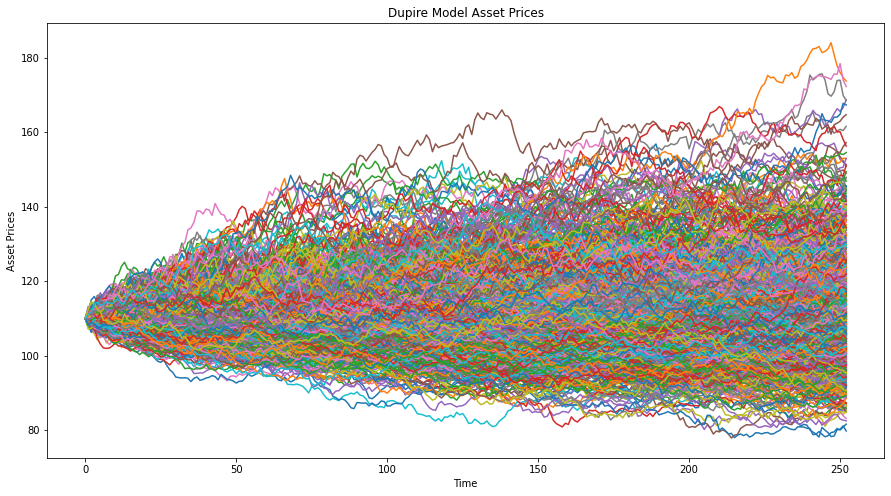

In [5]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_MC.T)
plt.title("Dupire Model Asset Prices")
plt.xlabel("Time")
plt.ylabel("Asset Prices")
plt.show()

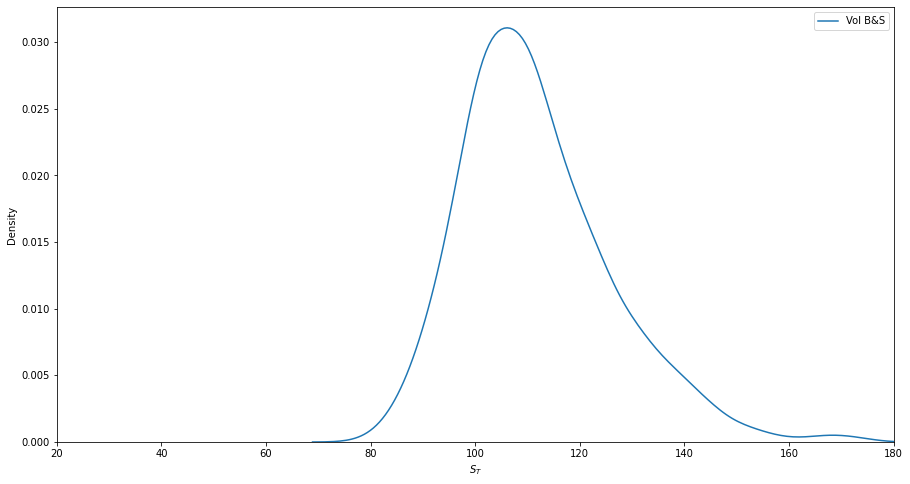

In [6]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.kdeplot(df_MC.T[252], label="Vol B&S", ax=ax)
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

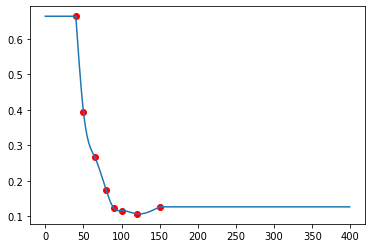

In [54]:
#check spline interpolation:
Maturité = 30
rlst = []
for j in range(0,400):
	rlst.append(Udl.Vol_Local.get_vol(Maturité, j))
plt.plot(rlst)
plt.scatter(Udl.Vol_Local.columns, Udl.Vol_Local.loc[Maturité,:], marker="o", color="red")
plt.show()

# Résoudre la distribution

In [26]:
class MarketDataTest:
    def __init__(self, Spot: float, Vol: float | VISurface, Taux: float | list[str, float], Div, Date: np.datetime64 = np.datetime64('today')) -> None:
        """
        Objet pour représenter un actif.

        Paramètres
        ----------
        Spot : float
            La valeur actuelle de l'actif.
        Vol : float
            La volatilité de l'actif en %.
        Taux : float
            Le taux d'intérêt de l'actif en %.
        Div : float
            Le taux de dividende de l'actif en %.
        Date : np.datetime64, optionnel
            La date pour les données de marché (par défaut, la date d'aujourd'hui).

        Méthodes
        ----------
        get_rate_curve(self, Maturité: float) -> float:
            Renvoie le taux pour une maturité spécifique.

        get_div_curve(self, Maturité: float) -> float:
            Renvoie les dividendes pour une maturité spécifique.

        get_vol(self, Maturité: float, Vol: float) -> float:
            Renvoie la volatilité implicite du sous-jacent.
        """
        self.Spot = float(Spot)
        self.Taux = Taux
        self.Div = Div
        self.Vol = Vol
        self.Date = Date

    #----------------------------------------------"Setting Up Variable"-----------------------------------------------#    
    @property
    def Taux(self) -> float | list[str, float]:
        return self._Taux
    @Taux.setter
    def Taux(self, value: float | list[str, float] | tuple | np.ndarray) -> float | list[str, float]:
        """
        Permet d'uniformiser le format de la courbe de taux afin que ce soit toujours
        une liste (important car minimize de spicy ne fonctionne pas avec des tupples)
        """
        if isinstance(value, float): self._Taux = value
        elif isinstance(value, (tuple, np.ndarray, list)): self._Taux = list(value)
        else: raise TypeError(f"Format de données des taux d'intérêt non reconnu: {type(value)}")
        
    @property 
    def Vol(self) -> float | VISurface:
        return self._Vol
    @Vol.setter
    def Vol(self, value: float | pd.DataFrame) -> float | VISurface:
        """
        Sets the volatility surface with the correct format.

        Parameters
        ----------
        value : float | pd.DataFrame
            Volatility surface data. Can be either a float or a pandas DataFrame.

        Raises
        ------
        TypeError
            If the format of the volatility surface data is not recognized.
        """
        if isinstance(value, float):
            self._Vol = value
            self.Vol_Local = None
        elif isinstance(value, pd.DataFrame):
            self._Vol = VISurface(value.copy())
            self._Vol.columns = (self._Vol.columns/100) * self.Spot 
            self.Vol_Local = self._get_local_vol_surface()
        else: raise TypeError(f"Format de données de VI non reconnu : {type(value)}")
    
    @property
    def Div(self) -> float:
        return self._Div
    @Div.setter
    def Div(self, value:float) -> float:
        if isinstance(value, float): self._Div = value
        else: TypeError(f"Format de données de div non reconnu : {type(value)}")
        
    def _get_local_vol_surface(self):
        df_local = pd.DataFrame(index=self.Vol.index, columns=self.Vol.columns)
        print(df_local)
        for M in self.Vol.index[1:]:
            T = M/365
            r = self.get_rate(T)
            q = self.get_div(T)
            prev_M = self.Vol.index[self.Vol.index.get_loc(M) - 1]
            for K in self.Vol.columns[1:-1]:
                sigma = self.Vol.get_vol(M,K)
                d = (np.log(self.Spot/K) + ((r-q)+(sigma**2)/2)*T) / (sigma*np.sqrt(T))
                prev_K = self.Vol.columns[self.Vol.columns.get_loc(K) - 1]
                next_K = self.Vol.columns[self.Vol.columns.get_loc(K) + 1]

                #Différence Finit
                partial_T = (self.Vol.get_vol(prev_M,K) - sigma) / ((M-prev_M)/365)
                partial_K = (self.Vol.get_vol(M,prev_K) - sigma) / (K-prev_K)
                second_partial_K = (self.Vol.get_vol(M,prev_K) - 2*sigma + self.Vol.get_vol(M,next_K)) / ((next_K-K) * (K-prev_K))

                #Formule
                numérateur= sigma**2 + 2*sigma*T*(partial_T + (r-q)*K*partial_K)
                dénominateur1 = (1+K*d*partial_K*np.sqrt(T))**2
                dénominateur2 = sigma * (K**2)*T*((second_partial_K - d*partial_K)**2)*np.sqrt(T)
                df_local.loc[M,K] = np.sqrt(numérateur / (dénominateur1+dénominateur2))
        self.Vol_Local = VISurface(df_local.iloc[1:,1:-1])
        return self.Vol_Local
            

    #--------------------------------------------"Acces to timedepend data"--------------------------------------------#
    def get_rate(self, Maturité: float) -> float:
        """
        Returns the interest rate for the given maturity.

        Parameters
        ----------
        Maturité : float
            Maturity for which the interest rate is to be calculated.

        Returns
        -------
        float
            Interest rate for the given maturity.

        Raises
        ------
        ValueError
            If the interest rates have not been specified.
        """
        if isinstance(self.Taux, float): return self.Taux
        elif isinstance(self.Taux, list): return NNS(get_paramNNS(self.Taux), Maturité)
        else: raise TypeError(f"Les taux d'interets n'ont pas été renseigné ou le type de la courbe de taux :{type(self.Taux)} n'est pas surpporté")

    def get_vol(self, Maturité:float, Strike:float)->float:
        if isinstance(self.Vol, float): return self.Vol
        if isinstance(self.Vol, VISurface): return self.Vol.get_vol(Maturité,Strike)
        else: raise TypeError(f"La volatilité n'a pas été renseigné ou le type de la nap de vol :{type(self.Vol)} n'est pas surpporté")

    def get_div(self, Maturité: float) -> float:
        if isinstance(self.Div, float): return self.Div
        else: raise TypeError(f"Le div yield n'a pas été renseigné ou le type du div yield :{type(self.Div)} n'est pas surpporté")


In [27]:
rate = load_rate("Data/RateFr.json")
nap_vol = load_VI("Data/Nap_Vol_SX5E.json")
Udl = MarketDataTest(Spot=100, Vol=nap_vol, Taux=rate, Div=0.02)
Udl.Vol

     30.0  40.0  50.0  65.0  80.0  90.0  100.0 120.0 150.0 200.0
30     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
90     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
180    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
365    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
730    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1095   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1460   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
1825   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2555   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
3650   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN


\\cmfrfi001\grmactions\People\Chevrier\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.spline_equation = {}
\\cmfrfi001\grmactions\People\Chevrier\3. Mémoire\ModuleFinance\finfunc.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.spline_equation = {}


,30.0,40.0,50.0,65.0,80.0,90.0,100.0,120.0,150.0,200.0
30,0.761244,0.761244,0.675985,0.511070,0.332453,0.210529,0.112958,0.173090,0.324390,0.362706
90,0.593664,0.577868,0.491955,0.368819,0.247037,0.172674,0.120722,0.126750,0.190933,0.276417
180,0.550059,0.477178,0.408221,0.312810,0.224714,0.172668,0.133132,0.118757,0.149377,0.216371
365,0.461395,0.399217,0.344178,0.273135,0.212187,0.177275,0.148911,0.125466,0.133774,0.161080
730,0.385877,0.336358,0.294272,0.241999,0.199474,0.176289,0.157459,0.137213,0.133585,0.145006
1095,0.357771,0.315469,0.279095,0.232932,0.196034,0.176688,0.161224,0.143605,0.138330,0.145220
1460,0.345359,0.306229,0.271684,0.228053,0.194280,0.176969,0.163420,0.147600,0.142113,0.148391
1825,0.340537,0.301371,0.267504,0.225342,0.193494,0.177640,0.165442,0.150636,0.144631,0.149312
2555,0.339499,0.301477,0.269123,0.229593,0.200348,0.186040,0.175260,0.161638,0.153910,0.155602
3650,0.340017,0.305174,0.275947,0.240914,0.214776,0.201894,0.192065,0.179204,0.170274,0.168168


In [28]:
Udl.Vol_Local

,40.0,50.0,65.0,80.0,90.0,100.0,120.0,150.0
90,0.729488,0.431052,0.323877,0.217281,0.155399,0.108104,0.174654,0.199651
180,0.397098,0.332639,0.251844,0.176597,0.132468,0.105607,0.153266,0.153677
365,0.318336,0.275897,0.220481,0.170139,0.138911,0.113612,0.138141,0.143982
730,0.267457,0.237826,0.200506,0.170752,0.153511,0.13656,0.130938,0.14133
1095,0.229252,0.204566,0.176742,0.160028,0.152794,0.144978,0.139096,0.132922
1460,0.210441,0.189655,0.168087,0.156882,0.153343,0.148535,0.144093,0.135819
1825,0.195765,0.179445,0.161403,0.153898,0.152096,0.148409,0.14612,0.141969
2555,0.177794,0.162807,0.145891,0.138466,0.136378,0.13226,0.12695,0.129009
3650,0.171207,0.156374,0.13904,0.130009,0.126756,0.122689,0.116713,0.115788


J'ai des valeurs tres bizarre pour le strike 120 car ça ne reste pas dynamques B&S

La formule que j'ai dans le juptyer notebook est la suivante nous allons rester mais cette fois-ci avec la vol local retourné par cette formule 

In [13]:
def _get_local_vol(Udl: MarketData):
    df_local = pd.DataFrame(index=Udl.Vol.index, columns=Udl.Vol.columns)
    for M in Udl.Vol.index[1:]:
        T = M/365
        r = Udl.get_rate(T)
        # q = Udl.get_div(T)
        q = 0.02
        prev_M = Udl.Vol.index[Udl.Vol.index.get_loc(M) - 1]
        for K in Udl.Vol.columns[1:-1]:
            sigma = Udl.Vol.get_vol(M,K)
            d = (np.log(Udl.Spot/K) + ((r-q)+(sigma**2)/2)*T) / (sigma*np.sqrt(T))
            prev_K = Udl.Vol.columns[Udl.Vol.columns.get_loc(K) - 1]
            next_K = Udl.Vol.columns[Udl.Vol.columns.get_loc(K) + 1]

            #Différence Finit
            partial_T = (Udl.Vol.get_vol(prev_M,K) - sigma) / ((M-prev_M)/365)
            partial_K = (Udl.Vol.get_vol(M,prev_K) - sigma) / (K-prev_K)
            second_partial_K = (Udl.Vol.get_vol(M,prev_K) - 2*sigma + Udl.Vol.get_vol(M,next_K)) / ((next_K-K) * (K-prev_K))

            #Formule
            numérateur= sigma**2 + 2*sigma*T*(partial_T + (r-q)*K*partial_K)
            dénominateur1 = (1+K*d*partial_K*np.sqrt(T))**2
            dénominateur2 = sigma * (K**2)*T*((second_partial_K - d*partial_K)**2)*np.sqrt(T)
            df_local.loc[M,K] = np.sqrt(numérateur / (dénominateur1+dénominateur2))
    return df_local
vol_local = _get_local_vol(Udl)
vol_local.iloc[1:,1:-1]

,40.0,50.0,65.0,80.0,90.0,100.0,120.0,150.0
90,0.729488,0.431052,0.323877,0.217281,0.155399,0.108104,0.174654,0.199651
180,0.397098,0.332639,0.251844,0.176597,0.132468,0.105607,0.153266,0.153677
365,0.318336,0.275897,0.220481,0.170139,0.138911,0.113612,0.138141,0.143982
730,0.267457,0.237826,0.200506,0.170752,0.153511,0.13656,0.130938,0.14133
1095,0.229252,0.204566,0.176742,0.160028,0.152794,0.144978,0.139096,0.132922
1460,0.210441,0.189655,0.168087,0.156882,0.153343,0.148535,0.144093,0.135819
1825,0.195765,0.179445,0.161403,0.153898,0.152096,0.148409,0.14612,0.141969
2555,0.177794,0.162807,0.145891,0.138466,0.136378,0.13226,0.12695,0.129009
3650,0.171207,0.156374,0.13904,0.130009,0.126756,0.122689,0.116713,0.115788


In [10]:
Udl.Vol

,30.0,40.0,50.0,65.0,80.0,90.0,100.0,120.0,150.0,200.0
30,0.761244,0.761244,0.675985,0.511070,0.332453,0.210529,0.112958,0.173090,0.324390,0.362706
90,0.593664,0.577868,0.491955,0.368819,0.247037,0.172674,0.120722,0.126750,0.190933,0.276417
180,0.550059,0.477178,0.408221,0.312810,0.224714,0.172668,0.133132,0.118757,0.149377,0.216371
365,0.461395,0.399217,0.344178,0.273135,0.212187,0.177275,0.148911,0.125466,0.133774,0.161080
730,0.385877,0.336358,0.294272,0.241999,0.199474,0.176289,0.157459,0.137213,0.133585,0.145006
1095,0.357771,0.315469,0.279095,0.232932,0.196034,0.176688,0.161224,0.143605,0.138330,0.145220
1460,0.345359,0.306229,0.271684,0.228053,0.194280,0.176969,0.163420,0.147600,0.142113,0.148391
1825,0.340537,0.301371,0.267504,0.225342,0.193494,0.177640,0.165442,0.150636,0.144631,0.149312
2555,0.339499,0.301477,0.269123,0.229593,0.200348,0.186040,0.175260,0.161638,0.153910,0.155602
3650,0.340017,0.305174,0.275947,0.240914,0.214776,0.201894,0.192065,0.179204,0.170274,0.168168


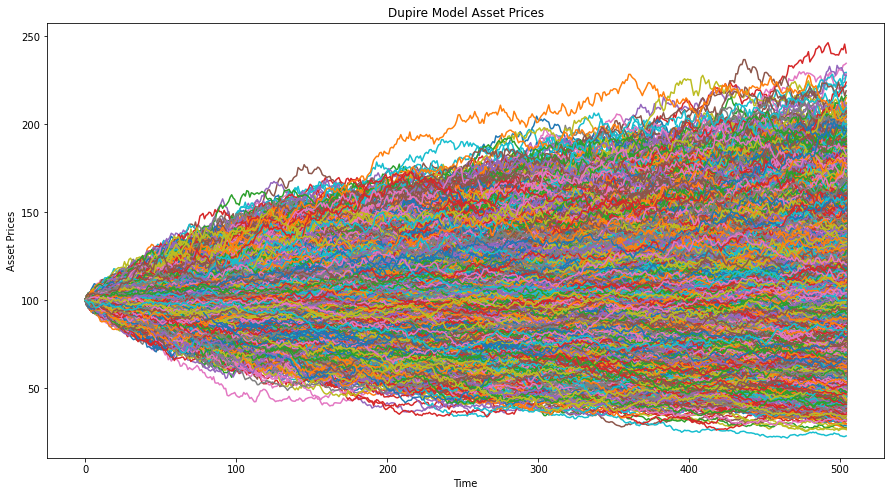

In [68]:
df_MC = MonteCarlo(New_Udl,2,252,250_000).vol_local()
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df_MC.T)
plt.title("Dupire Model Asset Prices")
plt.xlabel("Time")
plt.ylabel("Asset Prices")
plt.show()

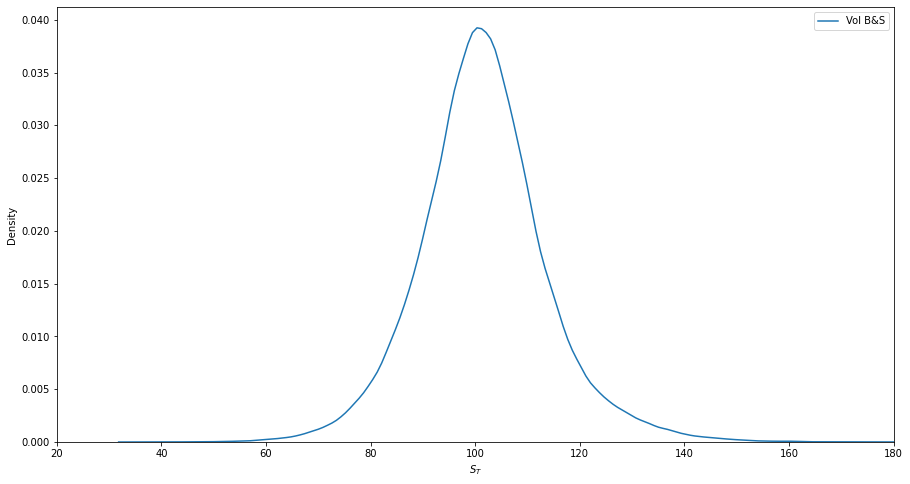

In [69]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.kdeplot(df_MC.T[252], label="Vol B&S", ax=ax)
plt.xlim([20, 180])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

In [72]:
New_Udl.Vol

,30.0,40.0,50.0,65.0,80.0,90.0,100.0,120.0,150.0,200.0
30,0.761244,0.761244,0.675985,0.511070,0.332453,0.210529,0.112958,0.173090,0.324390,0.362706
90,0.593664,0.577868,0.491955,0.368819,0.247037,0.172674,0.120722,0.126750,0.190933,0.276417
180,0.550059,0.477178,0.408221,0.312810,0.224714,0.172668,0.133132,0.118757,0.149377,0.216371
365,0.461395,0.399217,0.344178,0.273135,0.212187,0.177275,0.148911,0.125466,0.133774,0.161080
730,0.385877,0.336358,0.294272,0.241999,0.199474,0.176289,0.157459,0.137213,0.133585,0.145006
1095,0.357771,0.315469,0.279095,0.232932,0.196034,0.176688,0.161224,0.143605,0.138330,0.145220
1460,0.345359,0.306229,0.271684,0.228053,0.194280,0.176969,0.163420,0.147600,0.142113,0.148391
1825,0.340537,0.301371,0.267504,0.225342,0.193494,0.177640,0.165442,0.150636,0.144631,0.149312
2555,0.339499,0.301477,0.269123,0.229593,0.200348,0.186040,0.175260,0.161638,0.153910,0.155602
3650,0.340017,0.305174,0.275947,0.240914,0.214776,0.201894,0.192065,0.179204,0.170274,0.168168


In [73]:
New_Udl.Vol_Local

,40.0,50.0,65.0,80.0,90.0,100.0,120.0,150.0
90,0.729488,0.431052,0.323877,0.217281,0.155399,0.108104,0.174654,0.199651
180,0.397098,0.332639,0.251844,0.176597,0.132468,0.105607,0.153266,0.153677
365,0.318336,0.275897,0.220481,0.170139,0.138911,0.113612,0.138141,0.143982
730,0.267457,0.237826,0.200506,0.170752,0.153511,0.13656,0.130938,0.14133
1095,0.229252,0.204566,0.176742,0.160028,0.152794,0.144978,0.139096,0.132922
1460,0.210441,0.189655,0.168087,0.156882,0.153343,0.148535,0.144093,0.135819
1825,0.195765,0.179445,0.161403,0.153898,0.152096,0.148409,0.14612,0.141969
2555,0.177794,0.162807,0.145891,0.138466,0.136378,0.13226,0.12695,0.129009
3650,0.171207,0.156374,0.13904,0.130009,0.126756,0.122689,0.116713,0.115788


In [74]:
Udl.Vol_Local

,40.0,50.0,65.0,80.0,90.0,100.0,120.0,150.0
30,0.663241,0.394473,0.266037,0.172749,0.122424,0.116147,0.107111,0.12665
90,0.42166,0.241309,0.185186,0.138982,0.121525,0.131102,0.112654,0.084292
180,0.242701,0.206838,0.168266,0.142085,0.1357,0.145107,0.14343,0.093694
365,0.199836,0.178457,0.15632,0.144898,0.145396,0.153497,0.168158,0.118783
730,0.177706,0.165821,0.152315,0.148396,0.152575,0.159592,0.172899,0.15054
1095,0.177997,0.164737,0.150493,0.148959,0.154435,0.161158,0.172931,0.160415
1460,0.178074,0.162584,0.149297,0.149726,0.15636,0.163398,0.173302,0.162922
1825,0.182645,0.170093,0.159687,0.162716,0.170479,0.177412,0.18746,0.178441
2555,0.182584,0.17457,0.169865,0.177003,0.186789,0.194354,0.204256,0.20267
